# <center>Matching a subset of INSEE's SIREN File with a set of French Companies</center>

This notebook is part of a project that aims at cleaning INSEE's SIREN database to assign to each SIRET (French unique company id) a common name that every custommer can understand. <br>
This specific notebook transforms the data into a 3 dimensional sparse tensor and then uses a LSTM network, generating batches of the run using a custom keras generator.

## Imports

In [0]:
import numpy as np      
import pandas as pd
pd.set_option('display.max_columns', 100)
import slugify
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation, Bidirectional
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, History
#from tensorflow.keras import optimizers
from tensorflow.train import RMSPropOptimizer, AdamOptimizer

import matplotlib.pyplot as plt
import os
from time import gmtime, strftime
from scipy.sparse import csc_matrix

In [0]:
#from google.colab import drive
#drive.mount('drive')

In [0]:
#inputPath = "../Files/Generated_files/dataset_joined_preprocessed.csv"
#stopwords_path = "../Files/Raw_files/stopwords_fr.txt"

inputPath = "drive/My Drive/Google Colab/Societe/data/dataset_joined_preprocessed.csv"
stopwords_path = "drive/My Drive/Google Colab/Societe/data/stopwords_fr.txt"

SEED = 1234

## Reading the files

In [0]:
df = pd.read_csv(inputPath, low_memory=False, sep=";", encoding='utf-8', dtype='object')
df = df.fillna("")

In [7]:
df.head(5)

,activitePrincipaleEtablissement,activitePrincipaleRegistreMetiersEtablissement,activitePrincipaleUniteLegale,anneeCategorieEntreprise,anneeEffectifsEtablissement,anneeEffectifsUniteLegale,caractereEmployeurEtablissement,caractereEmployeurUniteLegale,categorieEntreprise,categorieJuridiqueUniteLegale,changementActivitePrincipaleEtablissement,changementCaractereEmployeurEtablissement,changementDenominationUsuelleEtablissement,changementEnseigneEtablissement,changementEtatAdministratifEtablissement,codeCedex2Etablissement,codeCedexEtablissement,codeCommune2Etablissement,codeCommuneEtablissement,codePaysEtranger2Etablissement,codePaysEtrangerEtablissement,codePostal2Etablissement,codePostalEtablissement,complementAdresse2Etablissement,complementAdresseEtablissement,dateCreationEtablissement,dateCreationUniteLegale,dateDebut,dateDernierTraitementEtablissement,dateDernierTraitementUniteLegale,dateFin,denominationUniteLegale,denominationUsuelle1UniteLegale,denominationUsuelle2UniteLegale,denominationUsuelle3UniteLegale,denominationUsuelleEtablissement,distributionSpeciale2Etablissement,distributionSpecialeEtablissement,economieSocialeSolidaireUniteLegale,enseigne1Etablissement,enseigne2Etablissement,enseigne3Etablissement,etablissementSiege,etatAdministratifEtablissement,etatAdministratifUniteLegale,identifiantAssociationUniteLegale,indiceRepetition2Etablissement,indiceRepetitionEtablissement,libelleCedex2Etablissement,libelleCedexEtablissement,libelleCommune2Etablissement,libelleCommuneEtablissement,libelleCommuneEtranger2Etablissement,libelleCommuneEtrangerEtablissement,libellePaysEtranger2Etablissement,libellePaysEtrangerEtablissement,libelleVoie2Etablissement,libelleVoieEtablissement,nic,nicSiegeUniteLegale,nomUniteLegale,nomUsageUniteLegale,nombrePeriodesEtablissement,nomenclatureActivitePrincipaleEtablissement,nomenclatureActivitePrincipaleUniteLegale,numeroVoie2Etablissement,numeroVoieEtablissement,prenom1UniteLegale,prenom2UniteLegale,prenom3UniteLegale,prenom4UniteLegale,prenomUsuelUniteLegale,pseudonymeUniteLegale,sexeUniteLegale,sigleUniteLegale,siren,siret,statutDiffusionEtablissement,statutDiffusionUniteLegale,trancheEffectifsEtablissement,trancheEffectifsUniteLegale,typeVoie2Etablissement,typeVoieEtablissement,unitePurgeeUniteLegale,label_true,core_banking,typeVoieEtablissement_corresp,adress,activitePrincipaleEtablissement_corresp
0,5610C,,56.10C,2016.0,2016.0,2016.0,O,O,GE,5720.0,0.0,0.0,0.0,0.0,0.0,,,,75113,,,,75013,,9-11,2008-01-01,2007-10-26,2008-01-01,2018-09-29T12:03:16,2018-09-29T12:03:16,,MC DONALDS PARIS SUD,,,,,,,,MCDONALD'S,,,0.0,A,A,,,,,,,paris-13,,,,,,de-choisy,92.0,19.0,,,1.0,NAFRev2,NAFRev2,,9,,,,,,,,,501137483,50113748300092,O,O,12,41,,av,,MC DONALD'S,MCDONALDS 866,avenue,9 avenue de-choisy 75013 paris-13,Restauration de type rapide
1,4711D,,47.11D,2016.0,2016.0,2016.0,O,O,PME,5710.0,0.0,0.0,0.0,1.0,0.0,,,,97413,,,,97436,,,1988-02-15,1988-02-15,2015-01-01,2018-09-29T12:36:32,2018-09-29T12:36:32,,CHONG-SI-TSAON ET LAO-OUINE ASSOCIES,MARCHE U,,,,,,,LEADER PRICE SAINT LEU,,,1.0,A,A,,,,,,,saint-leu,,,,,,du-general-lambert,15.0,15.0,,,6.0,NAFRev2,NAFRev2,,150,,,,,,,,CLA,344462908,34446290800015,O,O,12,12,,rue,,MARCHE U,MARCHE U ST LEU,rue,150 rue du-general-lambert 97436 saint-leu,Supermarchés
2,5610C,,56.10C,2016.0,2016.0,2016.0,O,O,GE,5720.0,0.0,0.0,0.0,0.0,0.0,,,,94021,,,,94550,,,2008-01-01,2007-10-26,2008-01-01,2018-09-29T12:02:56,2018-09-29T12:02:56,,MCDONALD S EST PARISIEN,,,,,,,,MCDONALD'S,,,0.0,A,A,,,,,,,chevilly-larue,,,,,,de-stalingrad,46.0,12.0,,,1.0,NAFRev2,NAFRev2,,344,,,,,,,,,500993969,50099396900046,O,O,12,41,,av,,MC DONALD'S,MCDONALDS 145,avenue,344 avenue de-stalingrad 94550 chevilly-larue,Restauration de type rapide
3,4711D,,47.11D,2016.0,2016.0,2016.0,O,O,PME,5499.0,1.0,0.0,0.0,1.0,0.0,,,,97207,,,,97224,,,1991-10-02,1991-10-02,2008-01-01,2018-09-29T12:12:54,2018-11-04T20:03:53,,SOC ALIMENTATION PETITE COCOTTE,,,,,,,,CASINO,,,0.0,A,A,,,,,,,ducos,,,,,,petite-cocotte,18.0,26.0,,,5.0,NAFRev2,N

# X Construction

## Cleaning function

In [0]:
def clean_string2(text):
    text = slugify.slugify(text)
    text = re.sub("[!\"(),.:;?`-]", " ", text) # remove punctuation (except ')
    text = re.sub("-", " ", text) # remove punctuation (except ')
    text = re.sub(" +", " ", text) # keep only one whitespace at a time
    return text

In [0]:
"""
    Apply the method given as argument to the column specified of the dataframe
    
    @ df : the dataframe on which we want to apply the methods
    @ list_col : the list of colums on which we want to apply the method
    @ method : the method we want to apply
"""

def apply_to_cols_df(df, list_col, fct):
    for col in list_col:
        df[col] = df[col].apply(fct)
    return df
  
#df.columns

## Generation of X

In [0]:
# We generate our X and y
y = pd.DataFrame(df["label_true"])
df_X = df.copy()
df_X.drop(columns=['label_true'],inplace=True)    

In [0]:
X = pd.DataFrame(df_X[["enseigne1Etablissement","enseigne2Etablissement","enseigne3Etablissement","denominationUsuelleEtablissement","activitePrincipaleEtablissement_corresp"]].apply(lambda x: ' '.join(x), axis=1))
#X = pd.DataFrame(df_X[["enseigne1Etablissement","enseigne2Etablissement","denominationUsuelleEtablissement","sigleUniteLegale","activitePrincipaleEtablissement_corresp"]].apply(lambda x: ' '.join(x), axis=1))

#X = pd.DataFrame(df_X[["enseigne1Etablissement","enseigne2Etablissement","enseigne3Etablissement","denominationUsuelleEtablissement","denominationUniteLegale","sigleUniteLegale","activitePrincipaleEtablissement_corresp"]].apply(lambda x: ' '.join(x), axis=1))
#X = pd.DataFrame(df_X[["enseigne1Etablissement","enseigne2Etablissement","enseigne3Etablissement","denominationUsuelleEtablissement","denominationUniteLegale","sigleUniteLegale","activitePrincipaleEtablissement_corresp"]].apply(lambda x: ' '.join(x), axis=1))
X = pd.DataFrame(df_X[["enseigne1Etablissement","enseigne2Etablissement","enseigne3Etablissement","denominationUsuelleEtablissement","denominationUniteLegale","sigleUniteLegale","activitePrincipaleEtablissement_corresp", 'denominationUsuelle1UniteLegale','denominationUsuelle2UniteLegale','denominationUsuelle3UniteLegale']].apply(lambda x: ' '.join(x), axis=1))


# Ajoutable : 'denominationUniteLegale', 'denominationUsuelle1UniteLegale', 'denominationUsuelle2UniteLegale', 'denominationUsuelle3UniteLegale', 'denominationUsuelleEtablissement', "sigleUniteLegale"

X = apply_to_cols_df(X, X.columns, clean_string2) # we clean the columns

In [12]:
X.head()

,0
0,mcdonald s mc donalds paris sud restauration d...
1,leader price saint leu chong si tsaon et lao o...
2,mcdonald s mcdonald s est parisien restauratio...
3,casino soc alimentation petite cocotte sapc su...
4,auchan supermarche auchan supermarche supermar...


## Splitting in array of words

In [13]:
X_split = []

func = (lambda row : X_split.append(row[0].split()))

np.apply_along_axis(func, axis=1, arr = X.values )

array([None, None, None, ..., None, None, None], dtype=object)

In [14]:
print('Nb of ex : ', len(X_split))
print('Ex1 length : ', len(X_split[0]))
print('Ex2 length : ', len(X_split[1]))
print('Ex6 length : ', len(X_split[5]))

Nb of ex :  18496
Ex1 length :  10
Ex2 length :  15
Ex6 length :  3


In [15]:
X_split[0]

['mcdonald',
 's',
 'mc',
 'donalds',
 'paris',
 'sud',
 'restauration',
 'de',
 'type',
 'rapide']

## Removing Stop Words

In [16]:
stop_words = pd.read_csv(stopwords_path, header=None)
stop_words.head(8)

,0
0,a
1,à
2,â
3,abord
4,afin
5,ah
6,ai
7,aie


In [17]:
stop_words = list(stop_words.values.ravel())
stop_words[:10]

['a', 'à', 'â', 'abord', 'afin', 'ah', 'ai', 'aie', 'ainsi', 'allaient']

In [0]:
X_cleaned = []

for sentence in X_split :
    new_sent = sentence
    i = 0
    while i < len(new_sent) :
        if new_sent[i] in stop_words :
            new_sent.pop(i)
        else : 
            i += 1
    X_cleaned.append(new_sent)

In [19]:
X_cleaned[:20]

[['mcdonald',
  'mc',
  'donalds',
  'paris',
  'sud',
  'restauration',
  'type',
  'rapide'],
 ['leader',
  'price',
  'saint',
  'leu',
  'chong',
  'tsaon',
  'lao',
  'ouine',
  'associes',
  'cla',
  'supermarches',
  'marche'],
 ['mcdonald', 'mcdonald', 'parisien', 'restauration', 'type', 'rapide'],
 ['casino',
  'soc',
  'alimentation',
  'petite',
  'cocotte',
  'sapc',
  'supermarches'],
 ['auchan', 'supermarche', 'auchan', 'supermarche', 'supermarches'],
 ['lilat', 'supermarches', 'intermarche'],
 ['soc', 'gest', 'exploit', 'supermarche', 'tang', 'sogest', 'superettes'],
 ['pathe',
  'pathe',
  'annecy',
  'decavision',
  'projection',
  'films',
  'cinematographiques',
  'decavision'],
 ['tobor', 'activites', 'sieges', 'sociaux'],
 ['foir',
  'fouille',
  'seynod',
  'distribution',
  'commerces',
  'detail',
  'magasin',
  'specialise',
  'foir',
  'fouille'],
 ['relais',
  'guidel',
  'nord',
  'bret',
  'commerce',
  'detail',
  'carburants',
  'magasin',
  'specialise']

## Converting to OneHotEncoding

In [20]:
X_in_df = pd.DataFrame(X_cleaned)
X_in_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,mcdonald,mc,donalds,paris,sud,restauration,type,rapide,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,leader,price,saint,leu,chong,tsaon,lao,ouine,associes,cla,supermarches,marche,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,mcdonald,mcdonald,parisien,restauration,type,rapide,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,casino,soc,alimentation,petite,cocotte,sapc,supermarches,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,auchan,supermarche,auchan,supermarche,supermarches,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [21]:
X_in_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
count,18496,18479,17725,15805,12935,10276,8161,6107,4753,3339,2404,1659,1151,838,574,363,266,176,89,61,35,16,8,5,4,2,1,1,1
unique,5447,4387,3492,2011,1341,988,723,610,526,455,360,270,187,150,121,83,65,50,28,25,15,10,7,5,4,2,1,1,1
top,lidl,supermarches,supermarches,detail,detail,magasin,specialise,magasin,specialise,specialise,specialise,m2et,animaux,specialise,specialise,magasin,specialise,specialise,relay,relay,shop,shop,shop,auto,duree,cards,superfourmi,bookin,cinevision
freq,1172,1693,1625,1586,1459,871,881,898,908,467,237,227,186,171,154,65,66,58,23,16,14,5,2,1,1,1,1,1,1


In [0]:
#max_len = X_in_df.shape[1]

max_len = 15

In [23]:
array_of_all_words = pd.unique(X_in_df.values.ravel())
array_of_all_words

array(['mcdonald', 'mc', 'donalds', ..., 'voxtur', 'bordere',
       'noirmoutrin'], dtype=object)

In [24]:
nb_mots_unique = array_of_all_words.shape[0]
nb_mots_unique

13286

In [0]:
to_id_dict = {}

i = 0
for elmt in array_of_all_words :
    to_id_dict[elmt] = i
    i += 1

In [26]:
to_id_dict['restaurant']

835

In [0]:
def listToOneHot(listOfWords, to_id_dict, max_len) :
    ohe = np.zeros((max_len, len(to_id_dict)))
    for i in range(len(listOfWords)) :
        if i < max_len :
            ohe[i, to_id_dict[listOfWords[i]]] = 1
    return csc_matrix(ohe)

In [0]:
X_final = []

for elmt in X_cleaned :
    X_final.append( listToOneHot(elmt, to_id_dict, max_len) )

In [29]:
X_final[0].toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
X = np.asarray(X_final).reshape((-1,1))

In [31]:
X.shape

(18496, 1)

# Y Construction

In [32]:
nb_label_unique = df['label_true'].unique().shape[0]
nb_label_unique

2885

In [33]:
Y = pd.get_dummies(df['label_true'])
Y.shape

(18496, 2885)

In [34]:
Y.head()

,1 ET 1 INTERNET SARL,10 DOIGTS,100000 CHAUSSURES,1001 PNEUS,1001PHARMACIES.COM,1055 ESPACE LOISIRS,123 ELEC,123ROULEMENT,1988 LIVE CLUB,8 A HUIT,A ' LIENOR,A ET E,A LA BONNE HEURE,A LA FOLIE,A.DEPEM,A2PAS,ACADOMIA,ACAJOU,ADIDAS,ADOPTE UN MEC,ADOUR DISTRIBUTION,ADSN,ADVERCITY,AEROBOUTIQUE,AEROPORT BALE MULHOUSE,AEROPORT BRETAGNE OUEST,AEROPORT CHARLES DE GAULLE,AEROPORT D'ORLY,AEROPORT DE BIARRITZ,AEROPORT DE RENNES,AEROPORT DE STRASBOURG-ENTZHEIM,AEROPORT GUADELOUPE POLE CARAIBES,AEROPORT MARSEILLE PROVENCE,AEROPORT MONTPELLIER MEDITERRANEE,AEROPORT PERPIGNAN,AEROPORT ROLAND GARROS,AEROPORT TOULOUSE-BLAGNAC,AEROPORTS DE LA COTE D'AZUR,AEROPORTS DE LYON,AEROPORTS DE PARIS,AFIBEL,AG ISSOUFALI DI,AGENCE GAF,AGGLO DE L'ALBIGEOIS,AGGLOMERATION AMIENS,AGGLOMERATION DE SOPHIA ANTIPOLIS,AGIP,AGRI SUD EST SA,AGRO-DISTRIBUTION,AIGLE AZUR,...,VIVRE BIO,VORWERK,VPG,VUILLERMET,VULCANIA,VULNERATOR,VVF VILLAGES,WALIBI,WALLABIES,WALLACE,WANDERLUST,WANIMO,WD DISTRIBUTION,WEBDEALAUTO.COM,WEEKENDESK.FR,WEEZEVENT,WEIGHT WATCHERS,WELDOM,WENGO PDM,WESTERN UNION,WHITEFIELDS,WIFIRST,WILISAMIDI,WILLEMSE,WIMEA,WINAMAX,WOK D'ASIE,WON-FAH-HIN,WONDERBOX,WOODBRASS.COM,WORLDPAY SARL,X-TREM,XANDRIE - QOBUZ,YAKAROULER,YES WE CAMP,YURPLAN,YVES ROCHER,YVETODIS,YVONNE,ZARA,ZARA FRANCE,ZARA HOME,ZENCO,ZEOP,ZODIO,ZOO DE LA PALMYRE,ZOO LA FLECHE,ZOO PARC DE BEAUVAL,ZOO SAINT-MARTIN LA PLAINE,ZUMO
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# RNN Model

In [0]:
# Params
size_lstm = 128
dropout = 0.3
batch_size = 32
nb_epoch = 15
learning_rate = 0.001

In [36]:
# create the model
K.clear_session()

# Create History for plotting
history = History()

# CODE-RNN2-2
# --- START CODE HERE

model = Sequential()
model.add(Bidirectional(LSTM(size_lstm, return_sequences = True), batch_input_shape=(None,max_len,nb_mots_unique))) #ou max_len pour le 2e
model.add(Dropout(dropout))
model.add(Bidirectional(LSTM(size_lstm, return_sequences = False)))
model.add(Dropout(dropout))
model.add(Dense(size_lstm))
model.add(Dense(512))
model.add(Dense(Y.shape[1]))
model.add(Activation('softmax'))

#opt = optimizers.RMSprop()
#opt = RMSPropOptimizer(learning_rate)
opt = AdamOptimizer(learning_rate)

# compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


model =  tf.contrib.tpu.keras_to_tpu_model(
   model,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.6.40.10:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13502763166037992737)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4595622123675339484)
INFO:tensorflow:*** Available Device: _DeviceAttri

In [0]:
def densify(array):
    return array[0].toarray()

def batch_generator(X, y, batch_size):
    n_batches_for_epoch = X.shape[0]//batch_size
    while True :
        shuffle_index = np.arange(np.shape(y)[0])
        np.random.shuffle(shuffle_index)
        X = X[shuffle_index]
        y = y.iloc[shuffle_index,:]
        for i in range(n_batches_for_epoch):
            index_batch = range(X.shape[0])[batch_size*i:batch_size*(i+1)]  
            X_batch = np.apply_along_axis(densify, 1, X[index_batch])
            y_batch = y.iloc[index_batch,:].values
            yield(X_batch,y_batch)

In [38]:
#model.fit(X, Y, epochs=10, batch_size=64, callbacks=[history])
model.fit_generator(generator = batch_generator(X, Y, batch_size),
                    epochs = nb_epoch, 
                    steps_per_epoch= int(X.shape[0]/batch_size),
                    callbacks=[history])

Epoch 1/15
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(4, 15, 13286), dtype=tf.float32, name='bidirectional_input_10'), TensorSpec(shape=(4, 2885), dtype=tf.float32, name='activation_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for bidirectional_input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 9.129226446151733 secs
INFO:tensorflow:Setting weights on TPU model.
578/578 [==============================] - 157s 272ms/step - loss: 3.8484 - acc: 0.3232
Epoch 2/15
578/578 [==============================] - 131s 227ms/step - loss: 2.1589 - acc: 0.6495
Epoch 3/15
578/578 [==============================] - 130s 224ms/step - loss: 1.6854 - acc: 0.7231
Epoch 4/15
578/578 [==============================

## Plotting

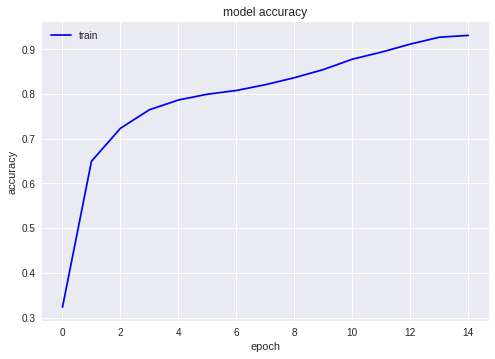

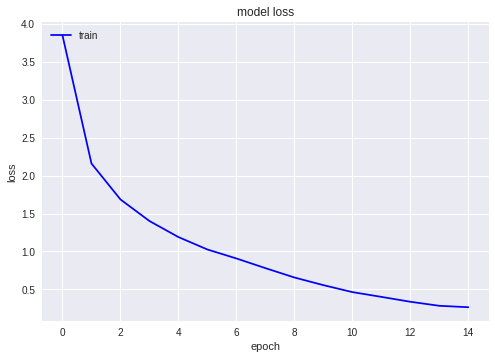

In [39]:
plt.plot(history.history['acc'],color = 'blue')
#plt.plot(history.history['val_acc'], color = 'blue')
plt.title('model accuracy')


plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'],color = 'blue')
#plt.plot(history.history['val_loss'], color = 'blue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
time = strftime("%Y-%m-%d_%H-%M", gmtime())

model_plot = pd.DataFrame(history.history)
model_plot.to_csv('drive/My Drive/Google Colab/Societe/model/model_societe-'+time)